# import

In [14]:
import sys
sys.path.append('/kaggle/input/absa-bert') 
from bert2 import bert_ATE, bert_ABSA
from dataset import dataset_ATM, dataset_ABSA

In [57]:
!pip install transformers

^C
ERROR: Operation cancelled by user


In [15]:
from torch.utils.data import DataLoader, ConcatDataset
from transformers import BertTokenizer
import torch
from torch.nn.utils.rnn import pad_sequence
import pandas as pd
import time
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [16]:
import pandas as pd  
df = pd.read_csv("/kaggle/input/absa-bert/restaurants_test.csv") 
df.head()['Tokens']

0    ['The', 'bread', 'is', 'top', 'notch', 'as', '...
1    ['I', 'have', 'to', 'say', 'they', 'have', 'on...
2    ['Food', 'is', 'always', 'fresh', 'and', 'hot'...
3    ['Did', 'I', 'mention', 'that', 'the', 'coffee...
4    ['Certainly', 'not', 'the', 'best', 'sushi', '...
Name: Tokens, dtype: object

In [17]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pretrain_model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(pretrain_model_name)
lr = 2e-5
model_ATE = bert_ATE(pretrain_model_name).to(DEVICE)
optimizer_ATE = torch.optim.Adam(model_ATE.parameters(), lr=lr)# adjusts weights
model_ABSA = bert_ABSA(pretrain_model_name,num_layers=2).to(DEVICE)
optimizer_ABSA = torch.optim.Adam(model_ABSA.parameters(), lr=lr)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.trans

In [18]:
def evl_time(t):
    min, sec= divmod(t, 60)
    hr, min = divmod(min, 60)
    return int(hr), int(min), int(sec)

def load_model(model, path):
    model.load_state_dict(torch.load(path), strict=False)
    return model
    
def save_model(model, name):
    torch.save(model.state_dict(), name)

# Apect Term Extraction

In [ ]:
sys.path.append('/kaggle/input/absa-bert/restaurants_test.csv')
restaurants_train_ds = dataset_ATM(pd.read_csv("/kaggle/input/absa-bert/restaurants_train.csv"), tokenizer)
restaurants_test_ds = dataset_ATM(pd.read_csv("/kaggle/input/absa-bert/restaurants_test.csv"), tokenizer)
type(restaurants_test_ds)

In [ ]:
# w,x,y,z = laptops_train_ds.__getitem__(121)
# print(w)
# print(x)
# print(x.size())
# print(y)
# print(y.size())
# print(z)
# print(z.size())

In [ ]:
train_ds = ConcatDataset([ restaurants_train_ds])
test_ds = ConcatDataset([ restaurants_test_ds])

In [ ]:
def create_mini_batch(samples):
    ids_tensors = [s[1] for s in samples]
    ids_tensors = pad_sequence(ids_tensors, batch_first=True)

    tags_tensors = [s[2] for s in samples]
    tags_tensors = pad_sequence(tags_tensors, batch_first=True)

    pols_tensors = [s[3] for s in samples]
    pols_tensors = pad_sequence(pols_tensors, batch_first=True)
    
    masks_tensors = torch.zeros(ids_tensors.shape, dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(ids_tensors != 0, 1)
    
    return ids_tensors, tags_tensors, pols_tensors, masks_tensors

In [ ]:
train_loader = DataLoader(train_ds, batch_size=5, collate_fn=create_mini_batch, shuffle = True)
test_loader = DataLoader(test_ds, batch_size=50, collate_fn=create_mini_batch, shuffle = True)

In [ ]:
# for batch in train_loader:
#     w,x,y,z = batch
#     print(w)
#     print(w.size())
#     print(x)
#     print(x.size())
#     print(y)
#     print(y.size())
#     print(z)
#     print(z.size())
#     break

In [ ]:
def train_model_ATE(loader, epochs):
    all_data = len(loader)
    for epoch in range(epochs):
        finish_data = 0
        losses = []
        current_times = []
        correct_predictions = 0
        
        for data in loader:
            t0 = time.time()
            ids_tensors, tags_tensors, _, masks_tensors = data
            ids_tensors = ids_tensors.to(DEVICE)
            tags_tensors = tags_tensors.to(DEVICE)
            masks_tensors = masks_tensors.to(DEVICE)

            loss = model_ATE(ids_tensors=ids_tensors, tags_tensors=tags_tensors, masks_tensors=masks_tensors,return_dict=False)
            losses.append(loss.item())
            loss.backward()
            optimizer_ATE.step()
            optimizer_ATE.zero_grad()

            finish_data += 1
            current_times.append(round(time.time()-t0,3))
            current = np.mean(current_times)
            hr, min, sec = evl_time(current*(all_data-finish_data) + current*all_data*(epochs-epoch-1))
            print('epoch:', epoch, " batch:", finish_data, "/" , all_data, " loss:", np.mean(losses), " hr:", hr, " min:", min," sec:", sec)         

        save_model(model_ATE, 'bert_ATE.pkl')
        
def test_model_ATE(loader,return_dict=False):
    pred = []
    trueth = []
    with torch.no_grad():
        for data in loader:

            ids_tensors, tags_tensors, _, masks_tensors = data
            ids_tensors = ids_tensors.to(DEVICE)
            tags_tensors = tags_tensors.to(DEVICE)
            masks_tensors = masks_tensors.to(DEVICE)

            outputs = model_ATE(ids_tensors=ids_tensors, tags_tensors=None, masks_tensors=masks_tensors,return_dict=False)

            _, predictions = torch.max(outputs, dim=2)

            pred += list([int(j) for i in predictions for j in i ])
            trueth += list([int(j) for i in tags_tensors for j in i ])

    return trueth, pred



In [ ]:
%time train_model_ATE(train_loader, 3)

In [ ]:
model_ATE = load_model(model_ATE, 'bert_ATE.pkl')

In [27]:
import seaborn as sns

In [ ]:
x, y = test_model_ATE(test_loader,return_dict=False)
print(classification_report(x, y, target_names=[str(i) for i in range(3)]))

In [ ]:
true_labels, predicted_labels = test_model_ATE(test_loader, return_dict=False)

# generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# plot confusion matrix as heatmap
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['0', '1', '2'], yticklabels=['0', '1', '2'])

# Aspect Based Sentiment Analysis

In [19]:
restaurants_train_ds = dataset_ABSA(pd.read_csv("/kaggle/input/absa-bert/restaurants_train.csv"), tokenizer)
restaurants_test_ds = dataset_ABSA(pd.read_csv("/kaggle/input/absa-bert/restaurants_test.csv"), tokenizer)

In [20]:
def create_mini_batch2(samples):
    ids_tensors = [s[1] for s in samples]
    ids_tensors = pad_sequence(ids_tensors, batch_first=True)

    segments_tensors = [s[2] for s in samples]
    segments_tensors = pad_sequence(segments_tensors, batch_first=True)

    label_ids = torch.stack([s[3] for s in samples])
    
    masks_tensors = torch.zeros(ids_tensors.shape, dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(ids_tensors != 0, 1)

    return ids_tensors, segments_tensors, masks_tensors, label_ids

In [21]:
train_ds = ConcatDataset([ restaurants_train_ds])
test_ds = ConcatDataset([ restaurants_test_ds])

train_loader = DataLoader(train_ds, batch_size=4, collate_fn=create_mini_batch2, shuffle = True)
test_loader = DataLoader(test_ds, batch_size=50, collate_fn=create_mini_batch2, shuffle = True)

In [ ]:
# for batch in train_loader:
#     w,x,y,z = batch
#     print(w)
#     print(w.size())
#     print(x)
#     print(x.size())
#     print(y)
#     print(y.size())
#     print(z)
#     print(z.size())
#     break

In [22]:


def train_model_ABSA(loader, epochs):
    writer = SummaryWriter()

    all_data = len(loader)
    for epoch in range(epochs):
        finish_data = 0
        losses = []
        current_times = []
        total_predictions = 0
        total_correct = 0

        for data in loader:
            t0 = time.time()
            ids_tensors, segments_tensors, masks_tensors, label_ids = data
            ids_tensors = ids_tensors.to(DEVICE)
            segments_tensors = segments_tensors.to(DEVICE)
            label_ids = label_ids.to(DEVICE)
            masks_tensors = masks_tensors.to(DEVICE)

            loss = model_ABSA(ids_tensors=ids_tensors, label_tensors=label_ids, masks_tensors=masks_tensors, segments_tensors=segments_tensors, return_dict=False)
            losses.append(loss.item())

            # Calculate accuracy
            predictions = torch.argmax(model_ABSA(ids_tensors=ids_tensors, label_tensors=None, masks_tensors=masks_tensors, segments_tensors=segments_tensors, return_dict=False), dim=1)
            total_predictions += label_ids.size(0)
            total_correct += (predictions == label_ids).sum().item()

            loss.backward()
            optimizer_ABSA.step()
            optimizer_ABSA.zero_grad()

            finish_data += 1
            current_times.append(round(time.time()-t0,3))
            current = np.mean(current_times)
            hr, min, sec = evl_time(current*(all_data-finish_data) + current*all_data*(epochs-epoch-1))
            accuracy = total_correct / total_predictions
            print('epoch:', epoch, " batch:", finish_data, "/" , all_data, " loss:", np.mean(losses), " accuracy:", accuracy, " hr:", hr, " min:", min," sec:", sec)         

            # Add loss and accuracy to TensorBoard
          

        # Save model and add checkpoint to TensorBoard
        save_model(model_ABSA, 'bert_ABSA4.pkl')
       

    # Close TensorBoard writer
    writer.close()
        
def test_model_ABSA(loader):
    pred = []
    trueth = []
    with torch.no_grad():
        for data in loader:

            ids_tensors, segments_tensors, masks_tensors, label_ids = data
            ids_tensors = ids_tensors.to(DEVICE)
            segments_tensors = segments_tensors.to(DEVICE)
            masks_tensors = masks_tensors.to(DEVICE)

            outputs = model_ABSA(ids_tensors, None, masks_tensors=masks_tensors, segments_tensors=segments_tensors, return_dict=False)
            
            _, predictions = torch.max(outputs, dim=1)

            pred += list([int(i) for i in predictions])
            trueth += list([int(i) for i in label_ids])

    return trueth, pred



In [ ]:
%time train_model_ABSA(train_loader, 4)

In [23]:
model_ABSA = load_model(model_ABSA, '/kaggle/working/bert_ABSA4.pkl')

In [24]:
%time x, y = test_model_ABSA(test_loader)
print(classification_report(x, y, target_names=[str(i) for i in range(3)]))

CPU times: user 6.46 s, sys: 138 ms, total: 6.59 s
Wall time: 9.68 s
              precision    recall  f1-score   support

           0       0.79      0.58      0.67       196
           1       0.60      0.41      0.49       196
           2       0.84      0.97      0.90       727

    accuracy                           0.80      1119
   macro avg       0.74      0.65      0.68      1119
weighted avg       0.79      0.80      0.79      1119



<AxesSubplot:>

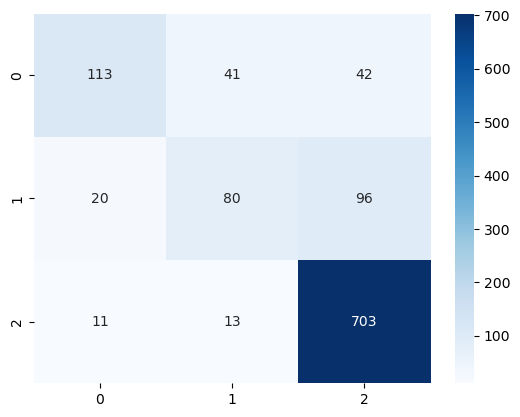

In [37]:
true_labels, predicted_labels = test_model_ABSA(test_loader)

# generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# plot confusion matrix as heatmap
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['0', '1', '2'], yticklabels=['0', '1', '2'])

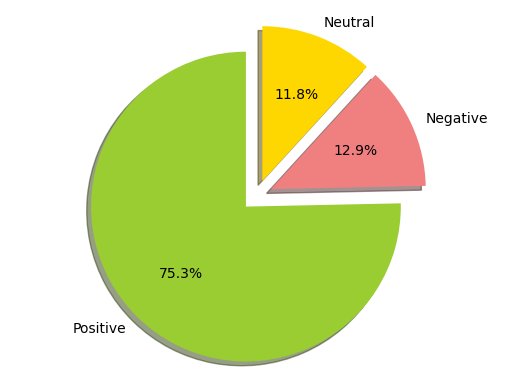

In [41]:
import matplotlib.pyplot as plt

# get the true and predicted polarities
true_polarities, predicted_polarities = test_model_ABSA(test_loader)

# count the number of occurrences for each polarity
pos_count = predicted_polarities.count(2)
neg_count = predicted_polarities.count(0)
neu_count = predicted_polarities.count(1)

# create the pie chart
labels = ['Positive', 'Negative', 'Neutral']
sizes = [pos_count, neg_count, neu_count]
colors = ['yellowgreen', 'lightcoral', 'gold']
explode = (0.1, 0.1, 0.1)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

plt.show()

# ATE + ABSA

In [42]:
def predict_model_ABSA(sentence, aspect, tokenizer,return_dict=False):
    t1 = tokenizer.tokenize(sentence)
    t2 = tokenizer.tokenize(aspect)

    word_pieces = ['[cls]']
    word_pieces += t1
    word_pieces += ['[sep]']
    word_pieces += t2

    segment_tensor = [0] + [0]*len(t1) + [0] + [1]*len(t2)

    ids = tokenizer.convert_tokens_to_ids(word_pieces)
    input_tensor = torch.tensor([ids]).to(DEVICE)
    segment_tensor = torch.tensor(segment_tensor).to(DEVICE)

    with torch.no_grad():
        outputs = model_ABSA(input_tensor, None, None, segments_tensors=segment_tensor,return_dict=False)
        _, predictions = torch.max(outputs, dim=1)
    
    return word_pieces, predictions, outputs

def predict_model_ATE(sentence, tokenizer,return_dict=False):
    word_pieces = []
    tokens = tokenizer.tokenize(sentence)
    word_pieces += tokens

    ids = tokenizer.convert_tokens_to_ids(word_pieces)
    input_tensor = torch.tensor([ids]).to(DEVICE)

    with torch.no_grad():
        outputs = model_ATE(input_tensor, None, None,return_dict=False)
        _, predictions = torch.max(outputs, dim=2)
    predictions = predictions[0].tolist()

    return word_pieces, predictions, outputs

def ATE_ABSA(text):
    terms = []
    word = ""
    x, y, z = predict_model_ATE(text, tokenizer,return_dict=False)
    for i in range(len(y)):
        if y[i] == 1:
            if len(word) != 0:
                terms.append(word.replace(" ##",""))
            word = x[i]
        if y[i] == 2:
            word += (" " + x[i])
            
    
    if len(word) != 0:
            terms.append(word.replace(" ##",""))
            
    #print("tokens:", x)
    #print("ATE:", terms)
    
    if len(terms) != 0:
        for i in terms:
            _, c, p = predict_model_ABSA(text, i, tokenizer)
            #print("term:", [i], "class:", [int(c)], "ABSA:", [float(p[0][0]), float(p[0][1]), float(p[0][2])])
            print("{term:","\"", i,"\"", ",class:", int(c),'}')

In [43]:
model_ABSA = load_model(model_ABSA, '/kaggle/working/bert_ABSA4.pkl')
model_ATE = load_model(model_ATE, '/kaggle/working/bert_ATE.pkl')

In [44]:
text = "For the price you pay this product is very good. However, battery life is a little lack-luster coming from a MacBook Pro."
ATE_ABSA(text)

{term: " battery life " ,class: 0 }


In [45]:
text = "The shrimp was pretty bad, but the service was great"
output = ATE_ABSA(text)

{term: " shrimp " ,class: 0 }
{term: " service " ,class: 2 }


# Cyberpunk 2077 - Xbox One

https://www.amazon.com/-/zh_TW/Cyberpunk-2077-Xbox-One/product-reviews/B07DJW4WZC/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=2

In [ ]:
text = "Spent 5 hours downloading updates."
ATE_ABSA(text)

In [ ]:
text = "Install is buggy, so after downloading a day one patch that's nearly 3 times the size of the game, it glitched on the CDs and had to reinstall the game from scratch."
ATE_ABSA(text)

In [ ]:
text = "Cyberpunk 2077 freezes constantly, frame rates are terrible, and it's extremely frustrating to try to play."
ATE_ABSA(text)

In [ ]:
text = "Cyberpunk 2077 is completely unplayable on xbox one. They should have never released this for current gen."
ATE_ABSA(text)

In [ ]:
text = "It’s just a cash grab, the game crashes constantly, runs at like 20 fps, half the environment and characters only load when you’re three feet away from them. Unless you’re in a small space the game looks awful. The worst game i’ve ever played in years visually. It looks worse than later xbox 360 games."
ATE_ABSA(text)

In [ ]:
text = "CD Projekt Red should have just abandoned the current gen consoles instead of cheating people out of their money."
ATE_ABSA(text)

In [ ]:
from IPython.display import FileLink
FileLink(r'/kaggle/working/bert_ATE.pkl')
FileLink(r'/kaggle/working/bert_ABSA2.pkl')

In [39]:
import os
os.chdir(r'/kaggle/working')

In [40]:
from IPython.display import FileLink
FileLink(r'bert_ABSA4.pkl')

/kaggle/working/bert_ABSA4.pkl